In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("seyeon040768/car-detection-dataset")

!cp {path}/* .

In [ ]:
import os
import numpy as np
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
import json

In [ ]:
def createDataFrame(image_path, label_path):
    bbox = []
    image_path = list(glob.glob(os.path.join(image_path, "*")))
    label = []

    for i in list(glob.glob(os.path.join(label_path, "*"))):
        with open(i) as f:
            temp = f.read().split(" ")
            temp = list(map(lambda x: float(x), temp))
            label = temp[0]
            temp = temp[1:]
            bbox.append(temp)

    data = pd.DataFrame(data={"image_path": image_path, "bbox": bbox, "label": label})
    return data


train_data = createDataFrame(
    "car_dataset-master/train/images", "car_dataset-master/train/labels"
)
test_data = createDataFrame(
    "car_dataset-master/test/images", "car_dataset-master/test/labels"
)
valid_data = createDataFrame(
    "car_dataset-master/valid/images", "car_dataset-master/valid/labels"
)

In [ ]:
def yolo_to_coco_bbox(yolo_bbox, img_width, img_height):
    x_center, y_center, width, height = yolo_bbox

    xmin = (x_center - width / 2) * img_width
    ymin = (y_center - height / 2) * img_height
    width = width * img_width
    height = height * img_height

    return [xmin, ymin, width, height]


In [ ]:
def createCOCODataset(dataframe):
    images = []
    categories = [{"id":0, "name":"car"}]
    annotations = []

    for i, (im_path, bbox, label) in enumerate(dataframe.values):
        img = cv2.imread(im_path)
        height = img.shape[0]
        width = img.shape[1]

        images.append({
            "width":width,
            "height":height,
            "id":i,
            "file_name":os.path.basename(im_path)
        })

        annotations.append({
            "id":i,
            "image_id":i,
            "category_id":int(label),
            "segmentation":[],
            "bbox":yolo_to_coco_bbox(bbox, width, height),
            "ignore":0,
            "iscrowd":0,
            "area":0
        })

        dataset_coco_format = {
            "categories": categories,
            "images": images,
            "annotations": annotations,
        }

    return dataset_coco_format



In [ ]:
train_coco = createCOCODataset(train_data)
test_coco = createCOCODataset(test_data)
valid_coco = createCOCODataset(valid_data)

In [ ]:
with open('train_coco.json', 'w', encoding='utf-8') as f:
    json.dump(train_coco, f, indent=4)
with open('test_coco.json', 'w', encoding='utf-8') as f:
    json.dump(test_coco, f, indent=4)
with open('valid_coco.json', 'w', encoding='utf-8') as f:
    json.dump(valid_coco, f, indent=4)

In [ ]:
!pip install git+https://github.com/facebookresearch/detectron2.git

In [2]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime
import matplotlib.pyplot as plt

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

In [3]:
# TRAIN SET
TRAIN_DATA_SET_NAME = f"train-coco"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join("car_dataset-master", "train","images")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join("train_coco.json"
)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME,
    metadata={},
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH,
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH,
)

# TEST SET
TEST_DATA_SET_NAME = f"test-coco"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join("car_dataset-master", "test","images")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(
"test_coco.json"
)

register_coco_instances(
    name=TEST_DATA_SET_NAME,
    metadata={},
    json_file=TEST_DATA_SET_ANN_FILE_PATH,
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH,
)

# VAL SET
VAL_DATA_SET_NAME = f"val-coco"
VAL_DATA_SET_IMAGES_DIR_PATH = os.path.join("car_dataset-master", "valid","images")
VAL_DATA_SET_ANN_FILE_PATH = os.path.join("valid_coco.json")

register_coco_instances(
    name=VAL_DATA_SET_NAME,
    metadata={},
    json_file=VAL_DATA_SET_ANN_FILE_PATH,
    image_root=VAL_DATA_SET_IMAGES_DIR_PATH,
)

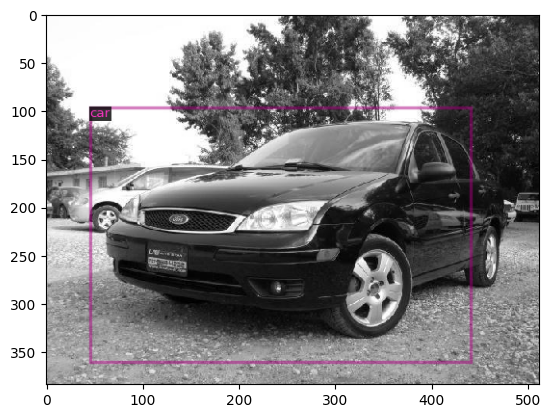

In [4]:
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[1]
image = cv2.imread(dataset_entry["file_name"])

visualizer = Visualizer(
    image[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE
)

out = visualizer.draw_dataset_dict(dataset_entry)
plt.imshow(out.get_image()[:, :, :])

In [37]:
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (VAL_DATA_SET_NAME,)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0001

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 #your number of classes + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 1

cfg.TEST.EVAL_PERIOD = 500
cfg.OUTPUT_DIR="faster_rcnn_R_101_FPN_3x"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [38]:
from detectron2.utils.logger import setup_logger
setup_logger()

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()






[12/25 13:20:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:01, 154MB/s]                               


[12/25 13:20:44 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/25 13:20:59 d2.utils.events]:  eta: 0:17:40  iter: 19  total_loss: 1.311  loss_cls: 0.6034  loss_box_reg: 0.6691  loss_rpn_cls: 0.005585  loss_rpn_loc: 0.02391    time: 0.7005  last_time: 0.6315  data_time: 0.0295  last_data_time: 0.0118   lr: 1.9981e-06  max_mem: 6909M
[12/25 13:21:13 d2.utils.events]:  eta: 0:17:22  iter: 39  total_loss: 1.349  loss_cls: 0.5944  loss_box_reg: 0.7044  loss_rpn_cls: 0.006664  loss_rpn_loc: 0.01622    time: 0.7010  last_time: 0.6348  data_time: 0.0143  last_data_time: 0.0117   lr: 3.9961e-06  max_mem: 6909M
[12/25 13:21:27 d2.utils.events]:  eta: 0:17:11  iter: 59  total_loss: 1.261  loss_cls: 0.5623  loss_box_reg: 0.6751  loss_rpn_cls: 0.005967  loss_rpn_loc: 0.0114    time: 0.7010  last_time: 0.5660  data_time: 0.0127  last_data_time: 0.0113   lr: 5.9941e-06  max_mem: 6909M
[12/25 13:21:40 d2.utils.events]:  eta: 0:16:45  iter: 79  total_loss: 1.187  loss_cls: 0.5215  loss_box_reg: 0.6379  loss_rpn_cls: 0.007285  loss_rpn_loc: 0.01151    time: 0.6

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir output

In [44]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!zip {cfg.OUTPUT_DIR}.zip {cfg.OUTPUT_DIR} -r

  adding: faster_rcnn_R_101_FPN_3x/ (stored 0%)
  adding: faster_rcnn_R_101_FPN_3x/model_final.pth

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


 (deflated 7%)
  adding: faster_rcnn_R_101_FPN_3x/events.out.tfevents.1735132859.64a567efffb9.393.1 (deflated 72%)
  adding: faster_rcnn_R_101_FPN_3x/metrics.json (deflated 78%)
  adding: faster_rcnn_R_101_FPN_3x/last_checkpoint (stored 0%)


In [40]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
predictor = DefaultPredictor(cfg)

[12/25 14:51:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from faster_rcnn_R_101_FPN_3x/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/25 14:52:35 d2.data.datasets.coco]: Loaded 1618 images in COCO format from test_coco.json


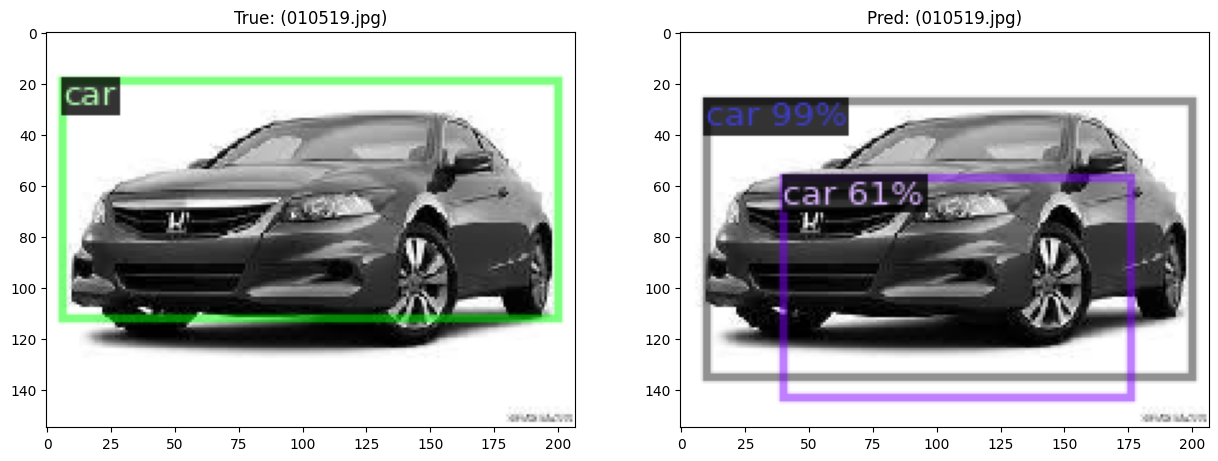

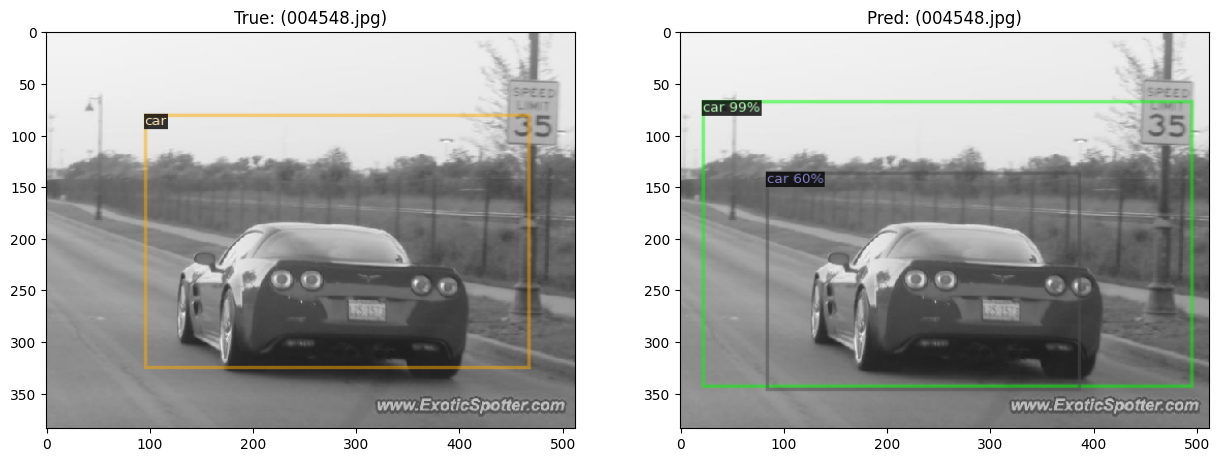

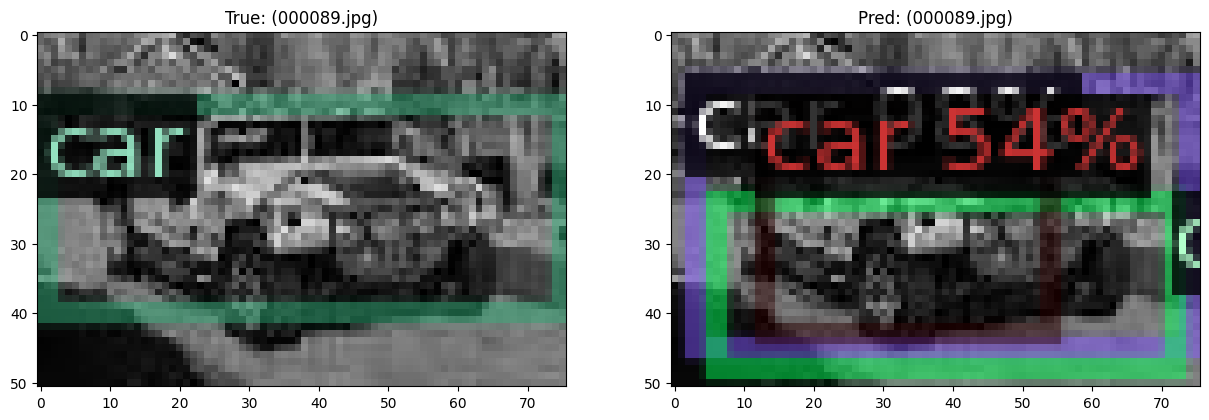

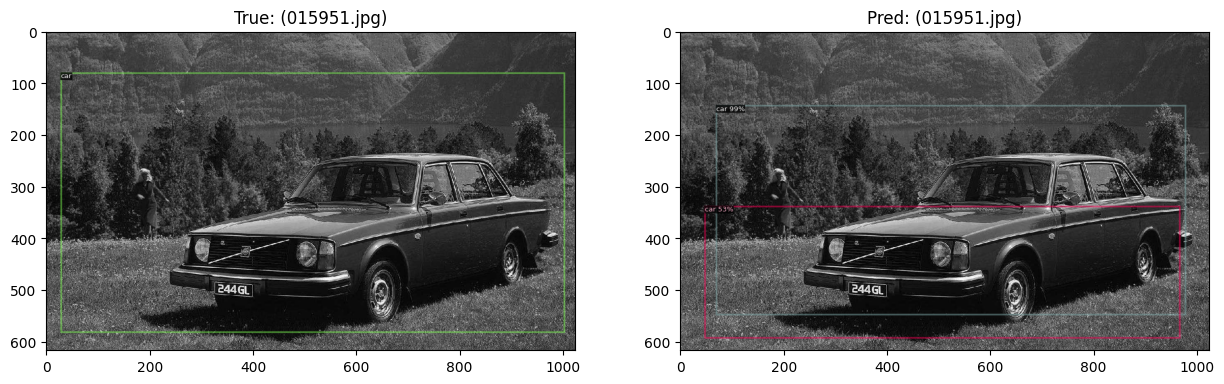

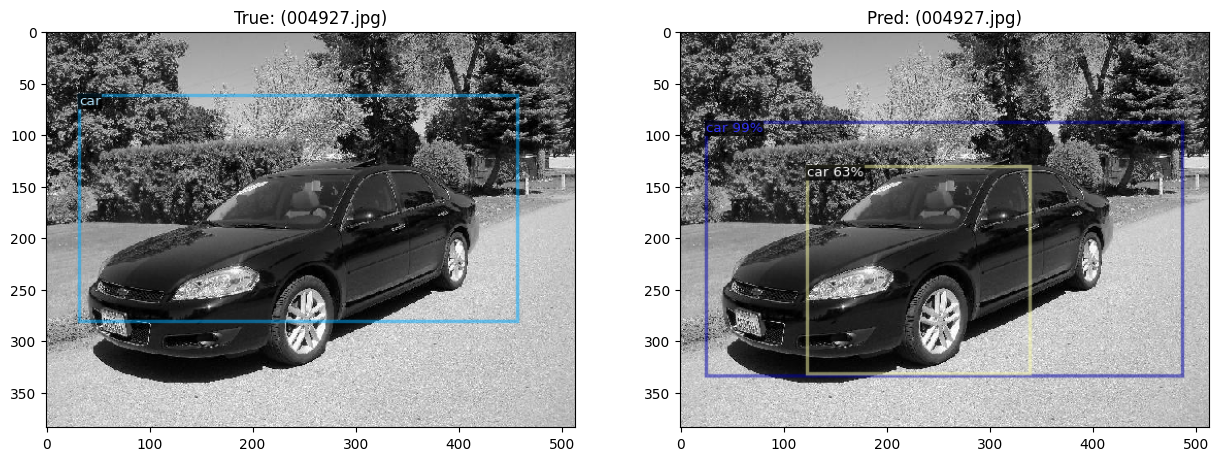

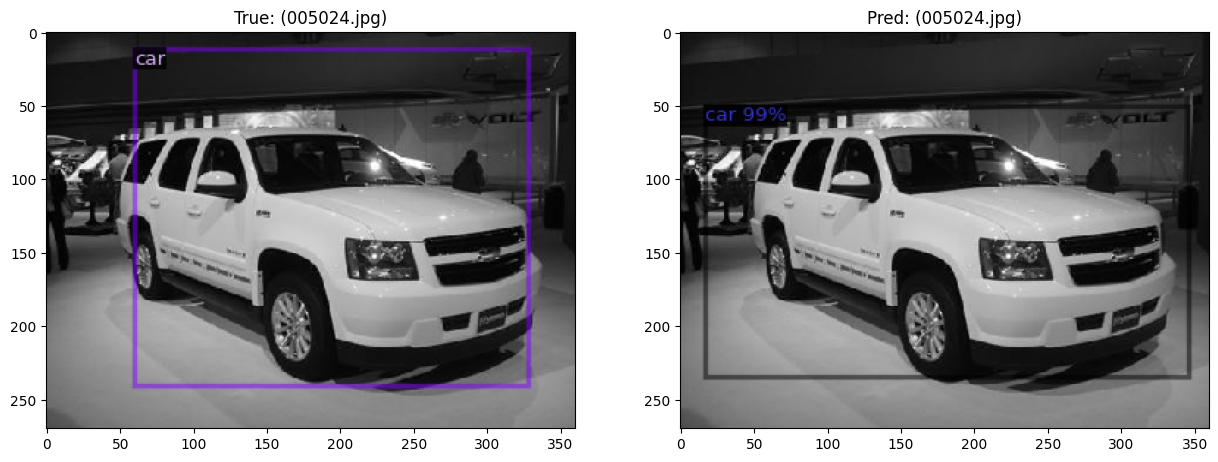

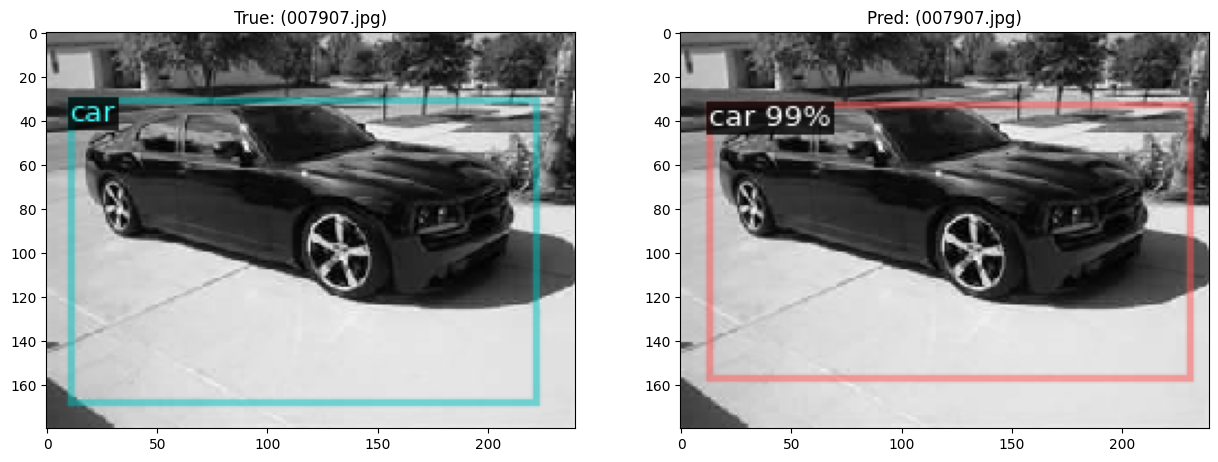

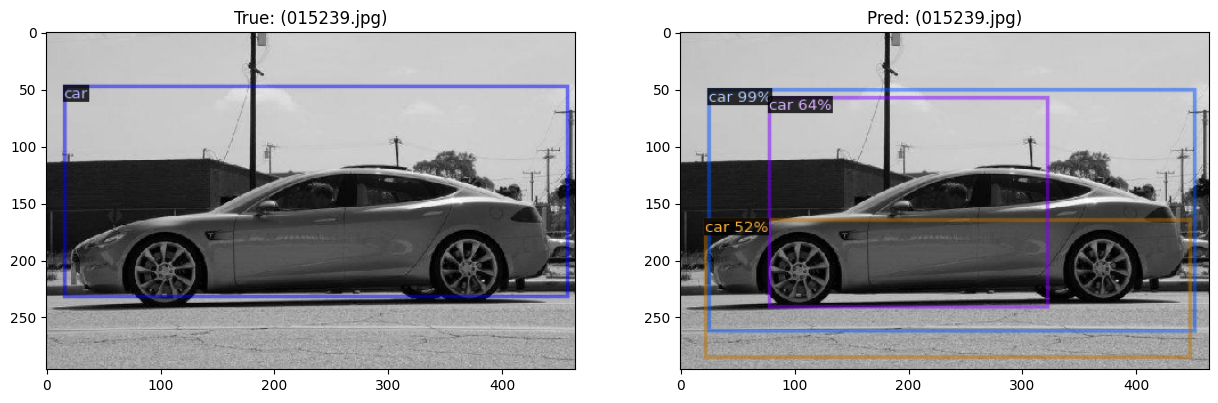

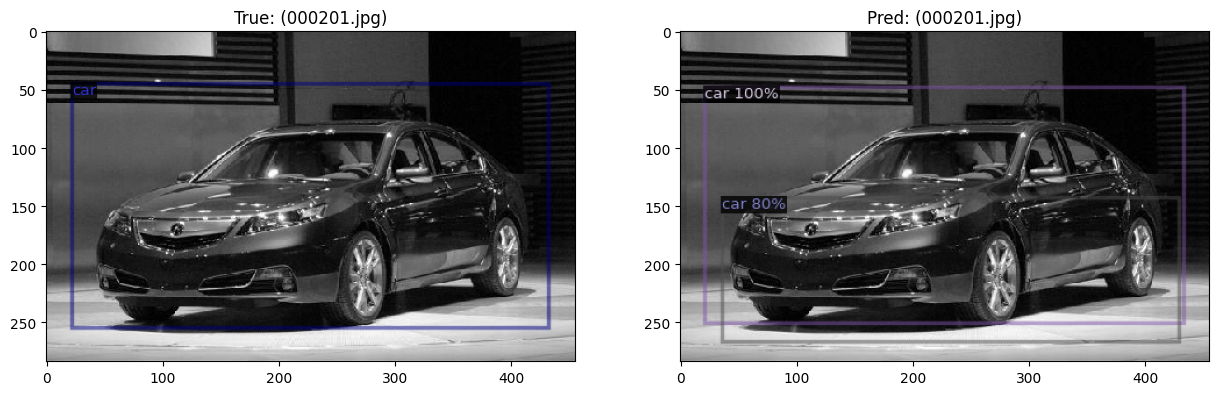

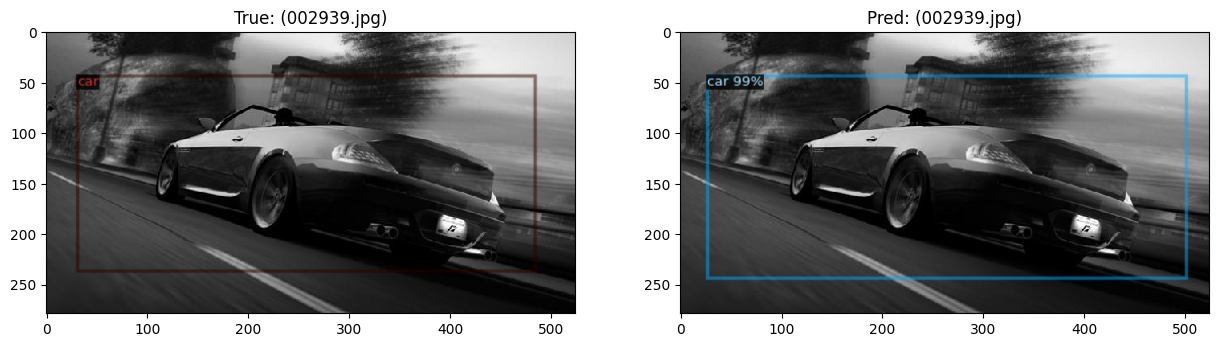

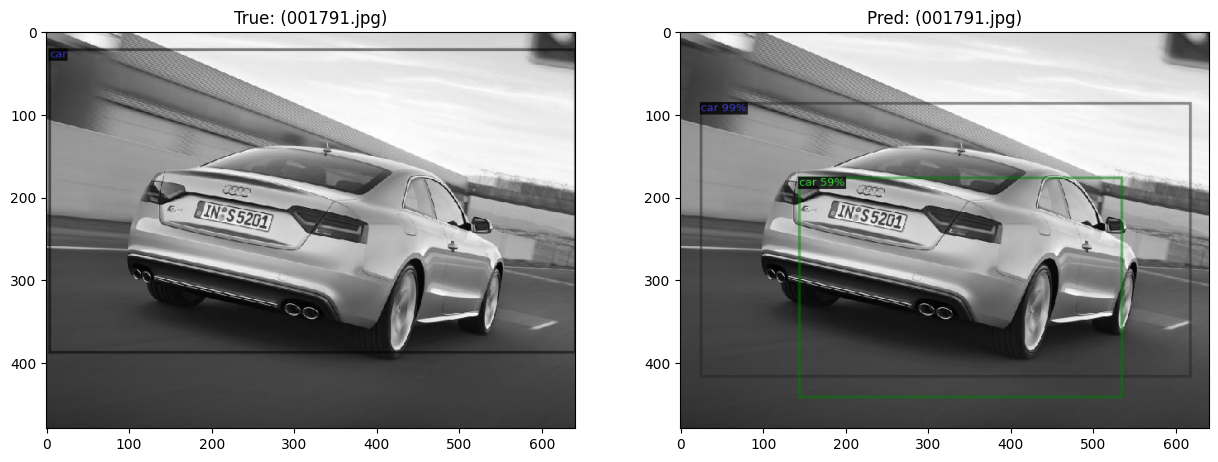

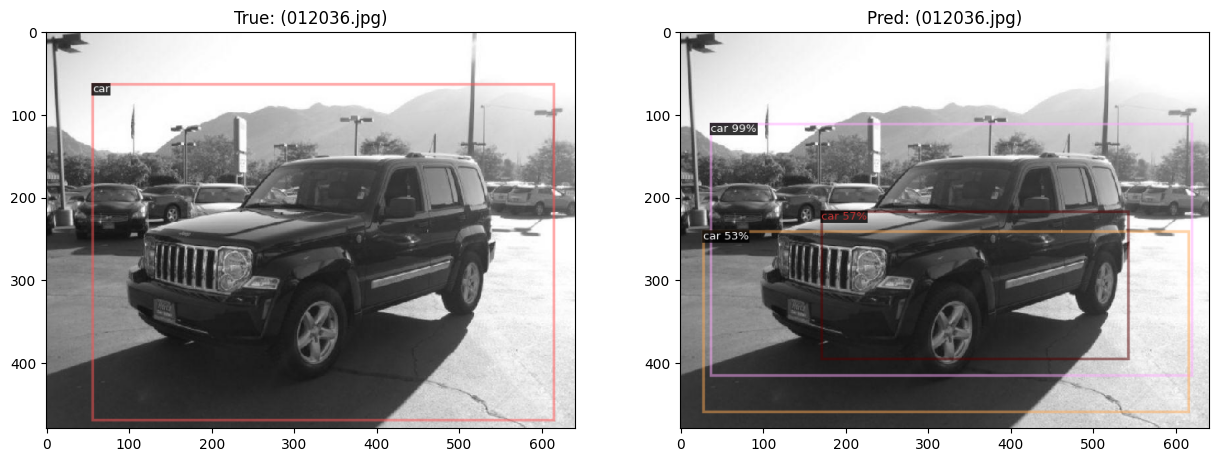

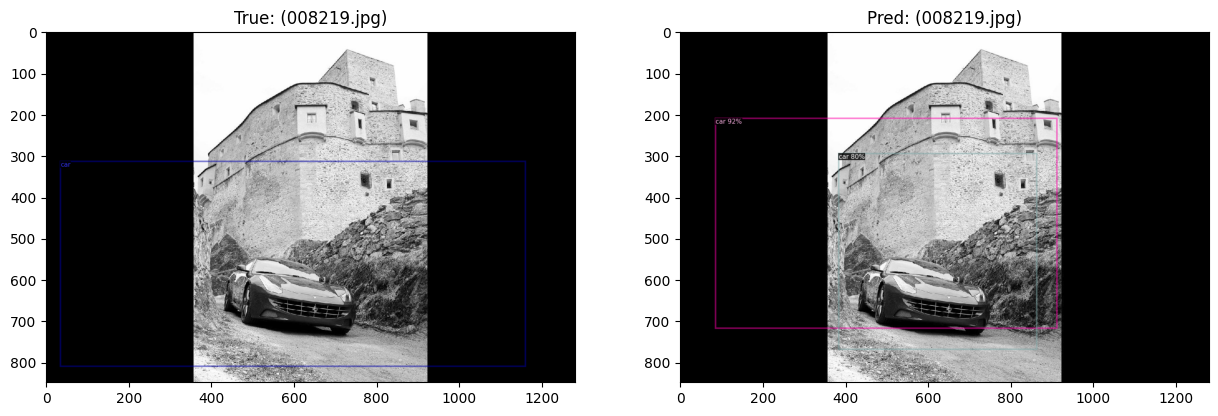

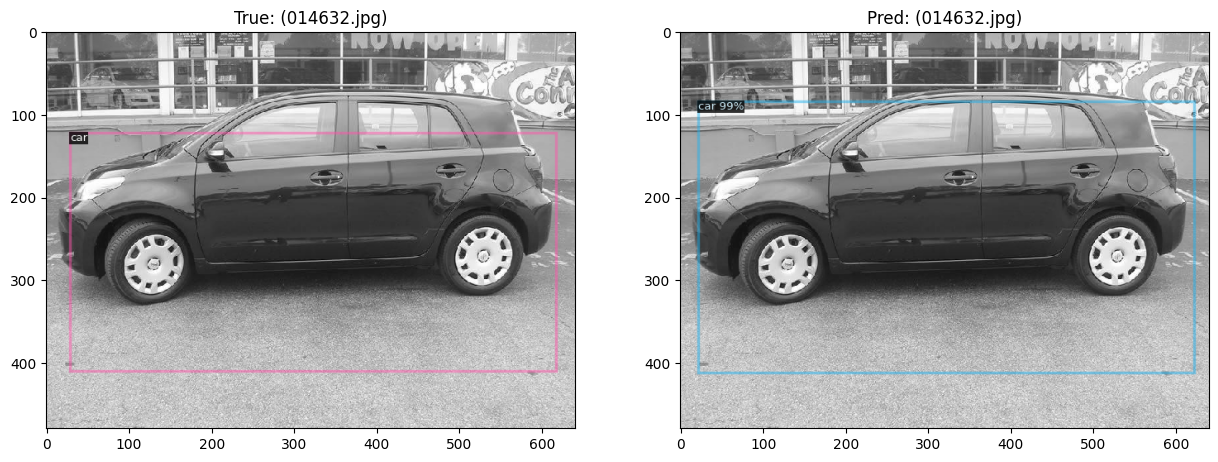

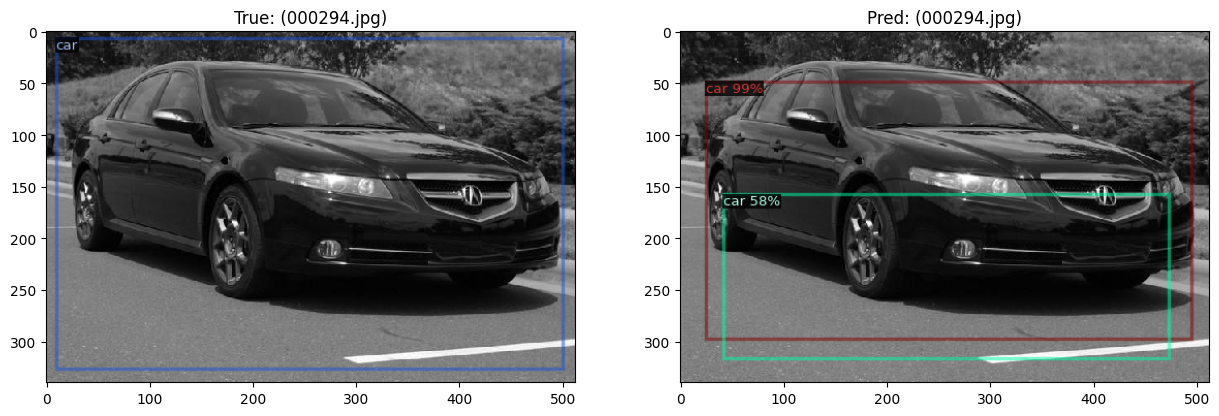

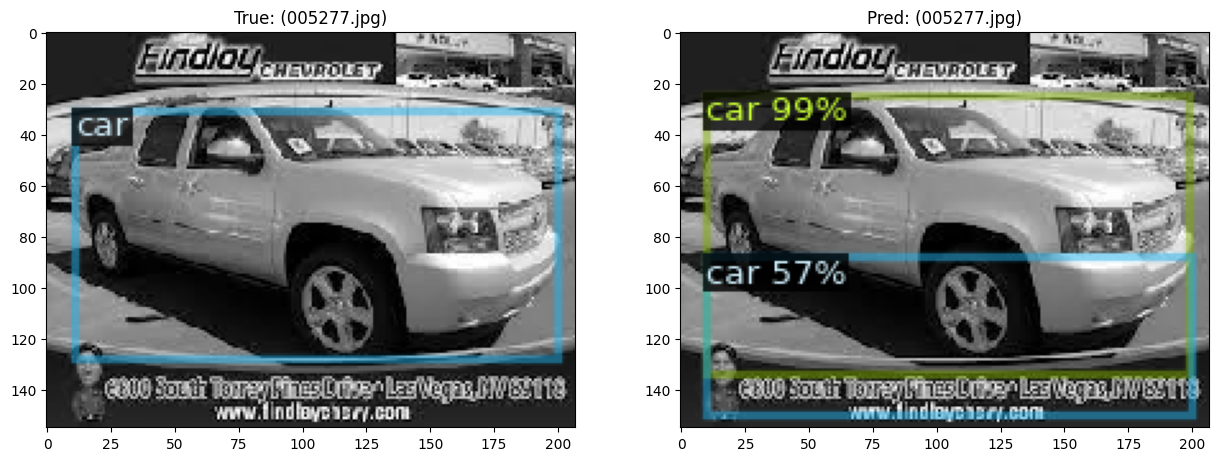

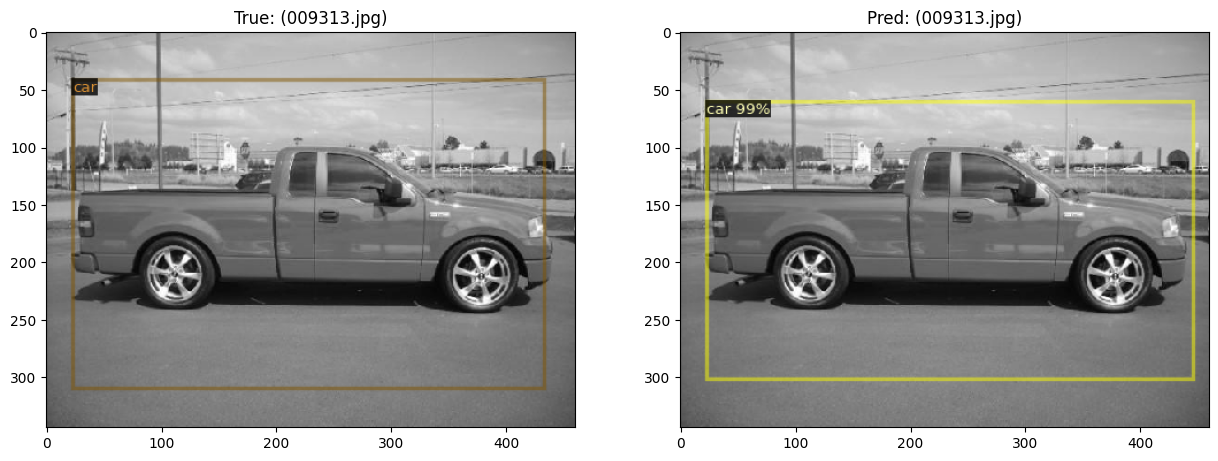

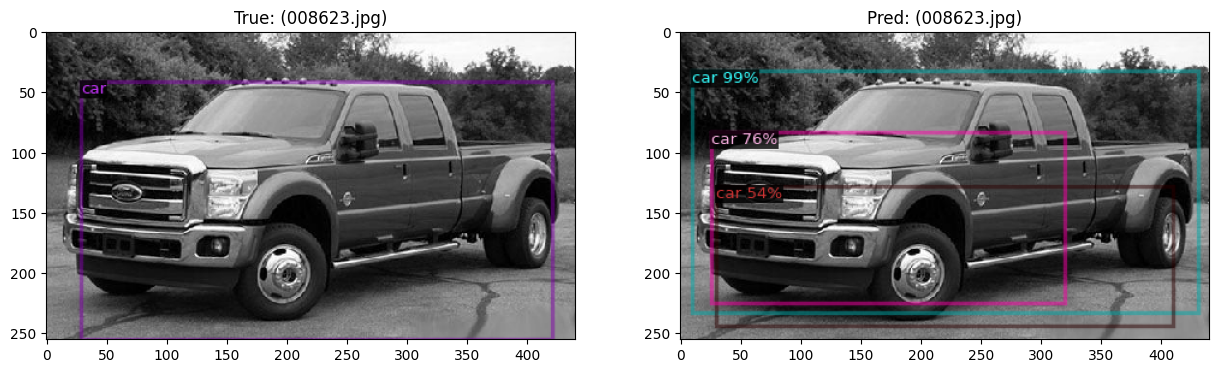

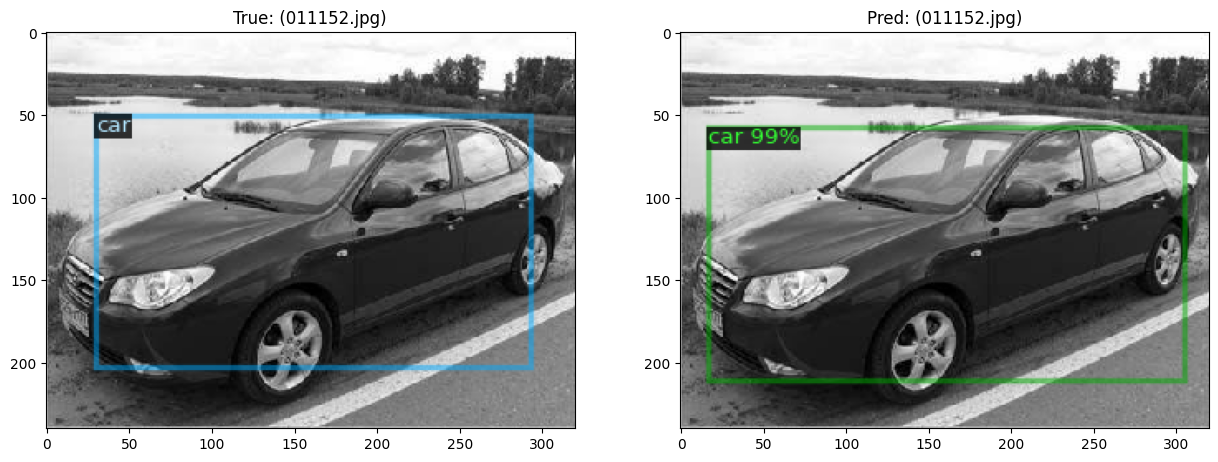

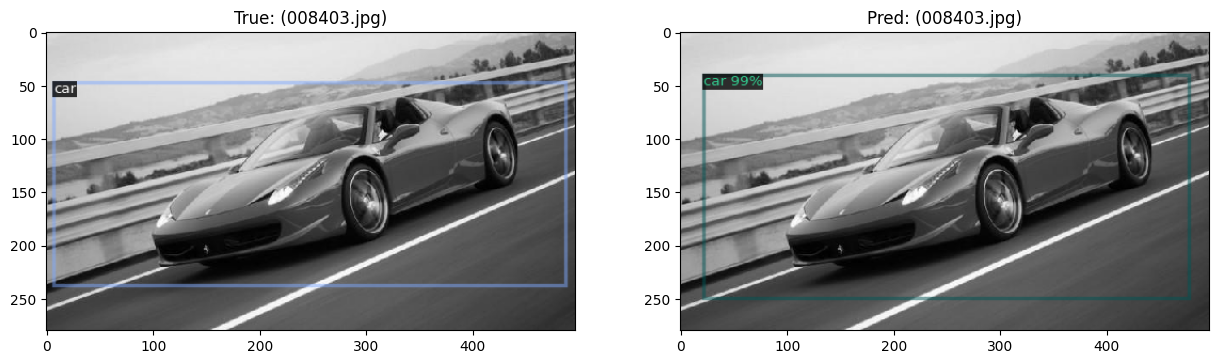

In [43]:
metadata = MetadataCatalog.get(TEST_DATA_SET_NAME)
dataset_test = DatasetCatalog.get(TEST_DATA_SET_NAME)

import torch

for d in dataset_test[:20]:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    instances = outputs["instances"].to("cpu")
    if len(instances) > 0:
        # Ambil skor dari setiap instance
        scores = instances.scores
        
        # Filter instances dengan skor lebih dari 0.6
        instances = instances[scores > 0.5]


    true_visualizer = Visualizer(
        img,
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE
    )
    pred_visualizer = Visualizer(
        img,
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE
    )

    out_true = true_visualizer.draw_dataset_dict(d).get_image()
    out_pred = pred_visualizer.draw_instance_predictions(instances).get_image()

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].set_title(f"True: ({os.path.basename(d['file_name'])})")
    ax[0].imshow(out_true[:,:,::-1])
    ax[1].set_title(f"Pred: ({os.path.basename(d['file_name'])})")
    ax[1].imshow(out_pred[:,:,::-1])
    plt.show()

In [16]:
dict(outputs['instances'])

NotImplementedError: `Instances` object is not iterable!